In [17]:
import numpy as np
import pandas as pd

In [ ]:
SEED = 11

df = pd.read_csv("../data/txn_df_with_fraud.csv", parse_dates=["TXN_DATETIME"])
cust_df = pd.read_csv("../data/intermediary/customer_df.csv")
term_df = pd.read_csv("../data/intermediary/terminal_df.csv")

In [19]:
df["HOUR"] = df["TXN_DATETIME"].dt.hour                 # hr of day (0-23)
df["DAY_OF_WEEK"] = df["TXN_DATETIME"].dt.dayofweek     # monday=0, sunday=6
df["IS_NIGHT"] = df["HOUR"].between(0, 4).astype(int)   # 12 AM to 4 AM

df = df.sort_values(["CUSTOMER_ID", "TXN_DATETIME"])
df["PREV_TXN_TIME"] = df.groupby("CUSTOMER_ID")["TXN_DATETIME"].shift(1)
df["SEC_SINCE_PREV"] = (df["TXN_DATETIME"] - df["PREV_TXN_TIME"]).dt.total_seconds()
df["SEC_SINCE_PREV"] = df["SEC_SINCE_PREV"].fillna(-1)

df["CUST_TXN_COUNT"] = df.groupby("CUSTOMER_ID").cumcount()

df["CUST_RUNNING_MEAN_AMT"] = (
    df.groupby("CUSTOMER_ID")["TRANSACTION_AMOUNT"]
       .expanding()
       .mean()
       .reset_index(level=0, drop=True)
       .shift(1)
)
df["CUST_RUNNING_MEAN_AMT"] = df["CUST_RUNNING_MEAN_AMT"].fillna(df["TRANSACTION_AMOUNT"].mean())

df["CUST_NIGHT_COUNT"] = df.groupby("CUSTOMER_ID")["IS_NIGHT"].cumsum().shift(1)
df["CUST_NIGHT_COUNT"] = df["CUST_NIGHT_COUNT"].fillna(0)
df["CUST_NIGHT_RATE"] = df["CUST_NIGHT_COUNT"] / df["CUST_TXN_COUNT"].replace(0, 1)

In [20]:
feature_cols = [
    "TRANSACTION_AMOUNT",
    "TXN_DAYS_ELAPSED",
    "HOUR",
    "DAY_OF_WEEK",
    "IS_NIGHT",
    "SEC_SINCE_PREV",
    "CUST_TXN_COUNT",
    "CUST_RUNNING_MEAN_AMT",
    "CUST_NIGHT_RATE",
    "MEAN_PURCHASE_AMOUNT",
    "STD_PURCHASE_AMOUNT"
]

df = df.merge(
    cust_df[["CUSTOMER_ID", "MEAN_PURCHASE_AMOUNT", "STD_PURCHASE_AMOUNT"]],
    on="CUSTOMER_ID",
    how="left"
)

X = df[feature_cols].fillna(0).values
y = df["IS_FRAUD"].values

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=SEED
)

print("train set size:", X_train.shape[0])
print("test set size:", X_test.shape[0])

train set size: 656711
test set size: 281448


In [27]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42))
    ]),
    "SGD Logistic": SGDClassifier(loss="log_loss", class_weight="balanced", max_iter=2000, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=150, max_depth=12, min_samples_leaf=2,
        n_jobs=-1, class_weight="balanced", random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=80, max_depth=3, learning_rate=0.1, random_state=42
    )
}

In [28]:
from sklearn.metrics import classification_report, roc_auc_score

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    results.append((name, auc))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.999     0.956     0.977    274500
           1      0.358     0.965     0.522      6948

    accuracy                          0.956    281448
   macro avg      0.679     0.960     0.750    281448
weighted avg      0.983     0.956     0.966    281448


=== SGD Logistic ===
              precision    recall  f1-score   support

           0      0.999     0.900     0.947    274500
           1      0.197     0.969     0.328      6948

    accuracy                          0.902    281448
   macro avg      0.598     0.935     0.638    281448
weighted avg      0.979     0.902     0.932    281448


=== ExtraTrees ===
              precision    recall  f1-score   support

           0      1.000     0.996     0.998    274500
           1      0.869     0.990     0.925      6948

    accuracy                          0.996    281448
   macro avg      0.934     0.993     0.962    281448
wei

In [29]:
df_results = pd.DataFrame(results, columns=["Model", "ROC_AUC"])
df_results

,Model,ROC_AUC
0,Logistic Regression,0.983542
1,SGD Logistic,0.934773
2,ExtraTrees,0.999607
3,GradientBoosting,0.998899


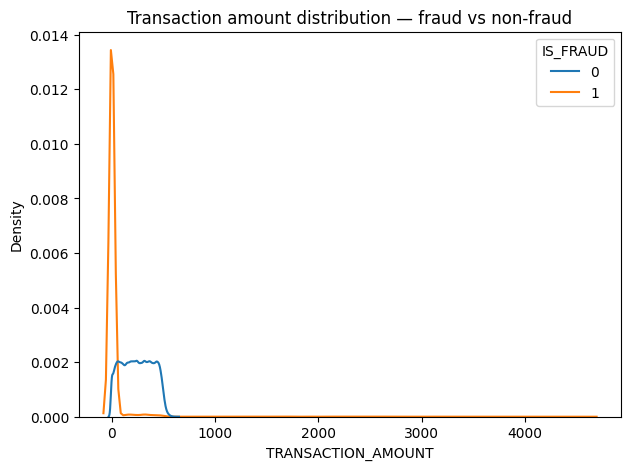

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.kdeplot(data=df, x="TRANSACTION_AMOUNT", hue="IS_FRAUD", common_norm=False)
plt.title("Transaction amount distribution — fraud vs non-fraud")
plt.show()

# explanation of plot shape:
NON-FRAUD TRANSACTIONS (BLUE CURVE):
- follow normal distribution w/ customer-specific mean and std, clipped @ min=0.
- since most customers had means within [20, 60], a dense cluster in [0, 200] and a tail cut off before ~800 makes sense.

FRAUD TRANSACTIONS (ORANGE CURVE):
1. go-big-or-go-home: injects very large amounts (5-10x mean_amt) which explains long orange tail reaching >4000.
2. under-wraps-rapid-fire: injects very small amounts multiple times over three days which creates a spike within [1, 5] as seen in the left-side peak.
3. night-owl: injects few nighttime transactions drawn from customer-specific normal txn distribution; very similar to non-fraudulent transactions which allows for overlap between the two curves.